# README

This notebook is a part of the implementation of ["Adversarial Network Traffic: Towards Evaluating the Robustness of Deep Learning-Based Network Traffic Classification"](https://arxiv.org/abs/2003.01261), including the implementation of packet classifiers PC-P, and PC-HP, and the implementation of End_AdvPad, End_RandPad, Start_AdvPad, and Start_AdvPad attacks.

following files and directories are required to replicate the results of the paper:
* PC/
  * Classifiers/
    * PC-HP_classifier
    * PC-P_classifier
  * AdvPad/
    * End_AdvPad_PC-HP/(adversarial pad)
    * End_AdvPad_PC-P/(adversarial pad)
    * Start_AdvPad_PC-HP/(adversarial pad)
    * Start_AdvPad_PC-P/(adversarial pad)
    * MAKED_PAD/
  * Dataset/
    * Dataset/PC-HP_Dataset.pickle
    * Dataset/PC-P_Dataset.pickle


The prerequisites for this notebook are as follows:
1. python 3.6
2. numpy 1.18.2
3. tensorflow-gpu 1.15
4. keras 2.2.5
5. pandas 1.0.3
6. pickle 4.0
7. matplotlib 3.2.1 

All codes have been run on [google colab](https://colab.research.google.com/).


# Configuration
This notebook must run four times in **separate sessions runtime** with different configs from top cell to bottom cell to replicate the results of the paper.

1.   End_AdvPad and End_RandPad attacks on PC-HP
  * PC = 'PC-HP' 
  * Attack_type = 'End'
  * Train_classifier = 0 
  * Load_AdvPad = 1 
2.   End_AdvPad and End_RandPad attacks on PC-P
  * PC = 'PC-P' 
  * Attack_type = 'End'
  * Train_classifier = 0 
  * Load_AdvPad = 1 
3.   Start_AdvPad and Start_RandPad attacks on PC-HP
  * PC = 'PC-HP' 
  * Attack_type = 'Start'
  * Train_classifier = 0 
  * Load_AdvPad = 1 
3.   Start_AdvPad and Start_RandPad attacks on PC-P
  * PC = 'PC-P' 
  * Attack_type = 'Start'
  * Train_classifier = 0 
  * Load_AdvPad = 1 

To train a new classifier, first, the input space must be determined by PC parameter, and then the parameter Train_classifier must set 1 (if you train a new classifier, then the new adversarial pad is generated. The kind of attack must be determined by PC and Attack_type parameters). The trained classifier is saved in PC/Classifiers directory.

For example, to train a new classifier PC-HP and to run End_AdvPad attack on it, the config is as follows: 
  * PC = 'PC-HP' 
  * Attack_type = 'End'
  * Train_classifier = 1 
  * Load_AdvPad = 0

To generate new adversarial pad on existing classifiers, first, the kind of attack must be determined by PC, and Attack_type parameters, and then the parameter Load_AdvPad must set 0. The generated adversarial pad is saved in PC/AdvPad/MAKED_PAD directory.

For example, to run Start_AdvPad attack on PC-P, the config is as follows:
  * PC = 'PC-P' 
  * Attack_type = 'Start'
  * Train_classifier = 0 
  * Load_AdvPad = 0 



In [0]:
#Config
PC = 'PC-HP' # PC-HP or PC-P
Attack_type = 'End' # Start oe End
Train_classifier = 0 # 0 -> Load existing classifiers, and 1 -> Train a new classifier with name Traind_Model in directory PC/Classifiers
Load_AdvPad = 1 # 0 -> Run AdvPad attack and will make new adversarial pad, and 1 -> Load existing adversarial pad that has been used in the paper

%cd 'drive/My Drive/ANT_Paper' # Location of the directory that contains PC files and directories

# Prerequisites

In [0]:
!pip install tensorflow-gpu==1.15.0
import tensorflow as tf
print(tf.__version__)
# Uninstall tensorflow first
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/content/drive/My Drive/ANT_Paper


1.15.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1047916719637571314, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7711830396181621201
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9348880253367421432
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7470045594
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6586198676289567996
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

# Utilization

In [0]:
import pandas as pd
import numpy as np
import time

#Data Config
INPUT_ITEMS = data.input_items # in PC-P = [Pay], and in PC-HP = [TL,Pay]
BATCH_SIZE = 128
IP_LENGTH = 40
TL_LENGTH = 60
Payload_LENGTH  = 2300



def padding_and_one_hot(d, l, input_items, input_length=None, num_classes=None,
                        ip_len=None,tl_len=None,pay_len=None):
    new_data = []
    for j in range(len(d)):
        ind = 0
        seq_ind = 0
        seq = np.zeros([input_length])
        if 'IP' in input_items:
            ip = np.pad(d[j][ind], (0, ip_len - len(d[j][ind])), mode='constant')
            ind += 1
            seq[seq_ind:seq_ind + ip_len] = ip
            seq_ind += ip_len
        if 'TL' in input_items:
            tl = np.pad(d[j][ind], (0, tl_len - len(d[j][ind])), mode='constant')
            ind += 1
            seq[seq_ind:seq_ind + tl_len] = tl
            seq_ind += tl_len
        if 'Payload' in input_items:
            pd = np.pad(d[j][ind], (0, pay_len - len(d[j][ind])), mode='constant')
            seq[seq_ind:seq_ind + pay_len] = pd
            seq_ind += pay_len
        new_data.append(seq)
    d = np.array(new_data).reshape([len(d), input_length, 1])
    l = np.eye(num_classes[0])[l]
    return d, l


def print_result_statistics(data, pred):
    index_name = data.traget_classification_index  # default is activity
    confusion_matrix = np.zeros([len(data.name[index_name]) + 1, len(data.name[index_name]) + 1])
    true_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    total_of_each_data_category = np.zeros((len(data.name[0]), len(data.name[1]), len(data.name[2])))
    true_count = 0
    total_count = len(data.test_data)
    for i in range(len(data.test_data)):
        type_label = np.where(data.name[0] == data.test_inf[i][-3])[0][0]
        app_label = np.where(data.name[1] == data.test_inf[i][-2])[0][0]
        act_label = np.where(data.name[2] == data.test_inf[i][-1])[0][0]
        dest_port = int(data.test_inf[i][3])
        total_of_each_data_category[type_label, app_label, act_label] += 1
        if np.argmax(pred[i]) == data.test_labels_1[i]:
            confusion_matrix[np.argmax(pred[i]), np.argmax(pred[i])] += 1
            true_of_each_data_category[type_label, app_label, act_label] += 1
            true_count += 1
        else:
            confusion_matrix[data.test_labels_1[i], np.argmax(pred[i])] += 1
    acc_of_each_data_category = np.round(true_of_each_data_category / total_of_each_data_category, 4) * 100
    f_score_array = np.zeros([len(data.name[index_name])])
    for i in range(len(data.name[index_name])):
        confusion_matrix[-1, i] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[:, i]), 4) * 100
        confusion_matrix[i, -1] = np.round(confusion_matrix[i, i] / np.sum(confusion_matrix[i, :]), 4) * 100
        f_score_array[i] =  np.round((2 * (confusion_matrix[-1, i] * confusion_matrix[i, -1])) / (confusion_matrix[-1, i] + confusion_matrix[i, -1]),2)
    confusion_matrix[-1, -1] = np.round(true_count / total_count, 4) * 100

    print("\n\nConfusion matrix: row, true label and column, predicted label\n")
    data_frame = pd.DataFrame(confusion_matrix, columns=np.append(data.name[index_name], ['Recall']),
                              index=np.append(data.name[index_name], ['Precision']))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(data_frame)
    print("\n\nOverall Accuracy = ", true_count / total_count)
    return np.array([f_score_array,confusion_matrix[-1, :6],confusion_matrix[:6, -1],np.round((true_count / total_count)*100,2)])
	
	
	

# PC Dataset

In [0]:
import numpy as np
import pandas as pd
class DATASET:
    def __init__(self,path= None,input_items=None,max_num_pkt_in_a_class=None,max_num_pkt_in_a_flow=None,
                 over_sampling=None,mix_train_test =None,ip_len=None,tl_len=None,pay_len=None):
        self.ip_attack = 0;self.input_items= 0;self.max_num_pkt_in_a_class = 0;self.max_num_pkt_in_a_flow = 0;self.over_sampling = 0;self.mix_train_test = 0;self.name = []
        self.train_data = 0;self.train_labels_1 = 0
        self.validation_data = 0;self.validation_data_port_attack = 0;self.validation_labels_1 = 0
        self.test_data = 0;self.test_data_port_attack = 0;self.test_labels_1 = 0;self.test_inf = np.array(test_inf)
        self.traget_classification_index = 0;self.target_classification_name = 0;self.num_of_classes = 0;self.input_len = 0
print("Dataset Loading ...",end=' ')
import pickle
if PC == 'PC-HP':
  file = open('PC/Dataset/PC-HP_Dataset.pickle','rb')
if PC == 'PC-P':
  file = open('PC/Dataset/PC-P_Dataset.pickle','rb')
data = pickle.load(file)
file.close()
train_data_stat = np.array([sum(data.train_labels_1 == i) for i in range(6)])
valid_data_stat = np.array([sum(data.validation_labels_1 == i) for i in range(6)])
test_data_stat = np.array([sum(data.test_labels_1 == i) for i in range(6)])
print("Dataset is loaded!!!")
print("\nNumber of data in Train:", data.train_data.shape[0], "Test", np.array(data.test_data).shape[0], "Validation",data.validation_data.shape[0])
print("\nNumber of data in each class:")
data_frame = pd.DataFrame([train_data_stat,valid_data_stat,test_data_stat,train_data_stat+valid_data_stat+test_data_stat], columns=data.name[2],
                              index=['Train Data','Validation data','Test data','Total'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data_frame)

Dataset Loading ... Dataset is loaded!!!

Number of data in Train: 322417 Test 104021 Validation 96825

Number of data in each class

                   chat  email  filetransfer  streaming  torrent    voip
Train Data       41646  39600         60505      60023    60625   60018
Validation data  10691   5416         20208      20033    20240   20237
Test data        16527   6833         20083      20102    20299   20177
Total            68864  51849        100796     100158   101164  100432


# PC Classifier Training
If Train_classifier parameter is 0, then this cell only shows the performance of the existing classifier on test set.

In [0]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU, ReLU
from keras.initializers import glorot_uniform
from keras.optimizers import Adamax, rmsprop


#Model Config
EPOCH = 100

def train(data, file_name, input_length, classes, num_epochs=100, batch_size=None, init=None,
          ip_len=None,tl_len=None,pay_len=None,load_path=None):
    """
    Standard neural network training procedure.
    """

    filter_num = ['None', 256, 128]
    kernel_size = ['None', 4, 8]
    conv_stride_size = ['None', 2, 2]
    pool_stride_size = ['None', 1]
    pool_size = ['None', 2]
    input_shape = (input_length, 1)

    Inputs = Input(shape=input_shape)

    x = Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=input_shape,
               strides=conv_stride_size[1], padding='same',
               name='block1_conv1')(Inputs)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(name='block1_adv_act1')(x)
    x = Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
               strides=conv_stride_size[2], padding='same',
               name='block1_conv2')(x)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(name='block1_adv_act2')(x)

    x = MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                     padding='same', name='block1_pool')(x)

    flat_x = Flatten(name='flatten')(x)
    x = Dense(256, kernel_initializer=glorot_uniform(seed=0), name='fc1')(flat_x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='fc1_act')(x)

    x = Dropout(0.1, name='fc1_dropout')(x)

    x = Dense(128, kernel_initializer=glorot_uniform(seed=0), name='fc2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='fc2_act')(x)

    x = Dropout(0.1, name='fc2_dropout')(x)

    x = Dense(classes[0], kernel_initializer=glorot_uniform(seed=0), name='fc3')(x)
    predictions_1 = Activation('softmax', name="softmax")(x)

    model = Model(inputs=Inputs, outputs=[predictions_1])
    if init != None:
        model.load_weights(init)

    OPTIMIZER = Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  # Optimizer
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
                  metrics=["accuracy"])
    print("Model compiled")
    if load_path != None:
        model = load_model(load_path)
        print("Model Loaded!")
    else:
        best_val_acc = 0
        for k in range(num_epochs):
            avg_loss = 0
            avg_acc = 0
            val_avg_acc = 0
            val_avg_loss = 0
            start_time = time.time()
            for i in range(int(len(data.train_data) / batch_size)):
                if i % 1000 == 0 or ((i+1)%int(len(data.train_data) / batch_size) == 0):
                    print(i,"/",int(len(data.train_data) / batch_size))
                batch_x = np.array(data.train_data[i * batch_size:(i + 1) * batch_size]) / 255
                batch_y = np.array(data.train_labels_1[i * batch_size:(i + 1) * batch_size])
                batch_x, batch_y = padding_and_one_hot(batch_x, batch_y, data.input_items, input_length,
                                                       num_classes=classes, ip_len=ip_len,tl_len=tl_len,pay_len=pay_len)
                history = model.train_on_batch(batch_x, batch_y)
                avg_acc += history[1]
                avg_loss += history[0]
            for i in range(int(len(data.validation_data) / batch_size)):
                batch_x = np.array(data.validation_data[i * batch_size:(i + 1) * batch_size]) / 255
                batch_y = np.array(data.validation_labels_1[i * batch_size:(i + 1) * batch_size])
                batch_x, batch_y = padding_and_one_hot(batch_x, batch_y, data.input_items, input_length,
                                                       num_classes=classes, ip_len=ip_len,tl_len=tl_len,pay_len=pay_len)
                history = model.test_on_batch(batch_x, batch_y)
                val_avg_acc += history[1]
                val_avg_loss += history[0]
            if np.round(val_avg_acc / int(len(data.validation_data) / batch_size), 4) > best_val_acc:
                model.save(file_name)
                print("Save_Best_Model")
                best_val_acc = np.round(val_avg_acc / int(len(data.validation_data) / batch_size), 4)
            elapsed_time = time.time() - start_time
            print("Epoch:", k, '/', num_epochs, '(', np.round(elapsed_time), ')', "Train_Loss:",
                  np.round(avg_loss / int(len(data.train_data) / batch_size), 4), "Train_Acc:",
                  np.round(avg_acc / int(len(data.train_data) / batch_size), 4), 'Val_Loss',
                  np.round(val_avg_loss / int(len(data.validation_data) / batch_size), 4), 'Val_Acc',
                  np.round(val_avg_acc / int(len(data.validation_data) / batch_size), 4))
        print("Best model is loading")
        model = load_model(file_name)



    print("Test")
    # Start evaluating model with testing data
    predicted_outputs = []
    for i in range(int(len(data.test_data) / batch_size)+1):
        if i % 100 == 0 or ((i+1)%int(len(data.test_data) / batch_size) == 0):
            print(i,"/",int(len(data.test_data) / batch_size))
        batch_x = np.array(data.test_data[i * batch_size:min(len(data.test_data),(i + 1) * batch_size)]) / 255
        batch_y = np.array(data.test_labels_1[i * batch_size:min(len(data.test_data),(i + 1) * batch_size)])
        batch_x, batch_y = padding_and_one_hot(batch_x, batch_y, data.input_items, input_length, num_classes=classes,
                                               ip_len=ip_len,tl_len=tl_len,pay_len=pay_len)
        pred = model.predict_on_batch(batch_x)
        if i == 0:
            predicted_outputs = pred
        else:
            predicted_outputs = np.append(predicted_outputs, pred, axis=0)
    
    print(model.summary())
    print_result_statistics(data, predicted_outputs)

    return model

if Train_classifier == 0:
    if PC == 'PC-HP':
        Classifier_load_path = "PC/Classifiers/PC-HP_classifier"
    if PC == 'PC-P':
        Classifier_load_path = "PC/Classifiers/PC-P_classifier"
    print(Classifier_load_path)
    model = train(data, "PC/Classifiers/Traind_Model", input_length=data.input_len, classes=data.num_of_classes,
                  num_epochs=EPOCH,batch_size=BATCH_SIZE,
                  ip_len=IP_LENGTH,tl_len=TL_LENGTH,pay_len=Payload_LENGTH, load_path=Classifier_load_path)
else:
    model = train(data, "PC/Classifiers/Traind_Model", input_length=data.input_len, classes=data.num_of_classes,
                  num_epochs=EPOCH,batch_size=BATCH_SIZE,
                  ip_len=IP_LENGTH,tl_len=TL_LENGTH,pay_len=Payload_LENGTH)
    print("Model has been saved in PC/Classifiers/Traind_Model")

PC/Classifiers/PC-HP_classifier






Using TensorFlow backend.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model compiled






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model Loaded!
Test
0 / 812
100 / 812
200 / 812
300 / 812
400 / 812
500 / 812
600 / 812
700 / 812
800 / 812
811 / 812
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2360, 1)           0         
_________________________________________________________________
block1_conv1 (Conv1D)        (None, 1180, 256)         1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1180, 256)         1024      
_________________________________________________________________
block1_adv_act1 (ReLU)       (None, 1180, 256)         0         
_____________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


# AdvPad Attack

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input
import time
from keras.models import load_model
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU, ReLU
from keras.initializers import glorot_uniform, glorot_normal, he_normal



class adversarial_padding():
    def __init__(self, keras_model_path=None, class_number=None, batch_size=None, packet_size=None):
        self.keras_model_path = keras_model_path
        self.class_number = class_number
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.batch_size = batch_size
        self.pkt_seq_size = packet_size
        self.load_advpad_operations()

    def make_adversarial_pad(self, data_x=None, data_y=None, advpad_size=None, proportional=None, trg_class=None,
                             lr=None, train_steps=1000, input_items=None,
                             src_class=None, ip_len=None, tl_len=None, pay_len=None):
        self.reset_advpad()
        if src_class == None:
            data_x = data_x[data_y != trg_class]
            data_y = data_y[data_y != trg_class]
        else:
            data_x = data_x[data_y == src_class]
            data_y = data_y[data_y == src_class]
        for i in range(train_steps):
            if i % 200 == 0:
                print('Step:', i, '/', train_steps)
            data_index = np.random.randint(len(data_x), size=self.batch_size)
            batch_x = data_x[data_index]
            batch_y = data_y[data_index]
            batch_x, batch_y = padding_and_one_hot(batch_x / 255, batch_y, input_items, self.pkt_seq_size,
                                                   num_classes=self.class_number, ip_len=ip_len, tl_len=tl_len,
                                                   pay_len=pay_len)
            size_of_packets = np.array([np.nonzero(x)[0][-1] for x in batch_x]).reshape((len(batch_x), 1)) + 1
            if Attack_type == 'End':
                start_index = np.array([np.nonzero(x)[0][-1] for x in batch_x]).reshape((len(batch_x), 1)) + 1
            if Attack_type == 'Start':
                if PC == 'PC-HP':
                  start_index = np.zeros((len(batch_x), 1)) + tl_len
                if PC == 'PC-P':
                  start_index = np.zeros((len(batch_x), 1))
            advpad_size_array = (advpad_size * size_of_packets).astype(np.int32)
            self.train_step(batch_x, batch_y, advpad_size=advpad_size_array, start_index=start_index, lr=lr)
        return self.adv_pad()

    def train_step(self, train_data, trg_label, advpad_size=None, start_index=None, lr=None):
        feed_dict = {self.pkt_seq_input: np.asarray(train_data).reshape([self.batch_size, self.pkt_seq_size, 1]),
                     self.target_y: trg_label,
                     self.learning_rate: lr,
                     self.start_loc_of_advpad_placeholder: start_index,
                     self.advpad_size_placeholder: advpad_size,
                     self.learning_phase: False,
                     self.dropout: 1.0}
        _, a, b, c, d, grad, loss, new_advpad, prob, paddedinput = self.sess.run(
            [self.train_op, self.before_start_mask_array, self.after_start_mask_array, self.shifted_data_array,
             self.advpad_mask, self.grad_opt, self.loss, self.pkt_advpad, self.probabilities, self.advpaded_input],
            feed_dict)

    def adv_pad(self, new_advpad=None):
        if new_advpad is None:
            return self.sess.run(self.clipped_advpad, {self.learning_phase: False})

        self.sess.run(self.assign_advpad, {self.advpad_placeholder: new_advpad, self.learning_phase: False})
        return self

    def gen_target_y(self, target_cls=None, size=None):
        label = target_cls
        y_one_hot = np.zeros(self.class_number)
        y_one_hot[label] = 1.0
        y_one_hot = np.tile(y_one_hot, (size, 1))
        return y_one_hot

    def reset_advpad(self):
        random_pad = np.random.randint(255, size=self.pkt_seq_size) / 255
        random_pad = random_pad.reshape([self.pkt_seq_size,1])
        self.adv_pad(random_pad)

    def load_advpad_operations(self):
        start = time.time()
        K.set_session(self.sess)
        with self.sess.graph.as_default():
            keras_model = pkt_classification_keras_model(self.keras_model_path, input_length=self.pkt_seq_size,
                                                         num_classes=self.class_number)

            self.learning_phase = K.learning_phase()  # if 1 -> train. if 0 -> test. (must be set in test or train time )
            pkt_shape = (self.pkt_seq_size, 1)
            self.pkt_seq_input = Input(shape=pkt_shape)  # input (set in test or train time )
            pkt_input = self.pkt_seq_input
            self.pkt_advpad = tf.Variable(initial_value=tf.zeros((self.pkt_seq_size, 1)), dtype=tf.float32,
                                          name="advpad")
            self.advpad_placeholder = tf.placeholder(dtype=tf.float32, shape=(self.pkt_seq_size, 1),
                                                     name='advpad_placeholder')
            self.start_loc_of_advpad_placeholder = tf.placeholder(dtype=tf.int32, shape=(None, 1),
                                                                  name='start_location_placeholder')
            self.advpad_size_placeholder = tf.placeholder(dtype=tf.int32, shape=(None, 1),
                                                          name='advpad_size_placeholder')
            self.assign_advpad = tf.assign(self.pkt_advpad,
                                           self.advpad_placeholder)
            self.modified_advpad = self.pkt_advpad

            def clip_to_valid_advpad(x):
                return tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.)

            self.clipped_advpad = clip_to_valid_advpad(
                self.modified_advpad)

            self.dropout = tf.placeholder_with_default(1.0, [])
            advpad_with_dropout = tf.nn.dropout(self.modified_advpad, keep_prob=self.dropout)
            advpaded_input = clip_to_valid_advpad(
                self.add_advpad_to_pkt_seq(pkt_input, advpad_with_dropout, self.start_loc_of_advpad_placeholder,
                                           advpad_size=self.advpad_size_placeholder))

            self.advpaded_input = advpaded_input

            self.target_y = tf.placeholder(tf.float32, shape=(None, self.class_number[0]), name="target_ys")

            self.logits = keras_model.predict([advpaded_input])

            self.loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
                labels=self.target_y,
                logits=self.logits
            )
            self.target_loss = tf.reduce_mean(self.loss_per_example)

            self.loss = self.target_loss * -1
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.grad_opt = self.optimizer.compute_gradients(self.loss, var_list=[self.pkt_advpad])
            self.train_op = self.optimizer.apply_gradients(self.grad_opt)

            self.probabilities = tf.nn.softmax(logits=self.logits)
            elapsed = time.time() - start
            print("Finished loading , took {:.0f}s".format(elapsed))
            self.sess.run(tf.variables_initializer(self.optimizer.variables()))

    def add_advpad_to_pkt_seq(self, data, advpad, start_advpad_index, advpad_size):

        stacked_advpad = tf.stack([advpad] * self.batch_size)
        self.clean_data_seq = data
        before_start_mask = []
        after_start_mask = []

        def mask_vecs(start, size):
            before_start_mask = np.zeros([self.pkt_seq_size, 1])
            before_start_mask[:start[0]] = 1
            after_start_mask = np.zeros([self.pkt_seq_size, 1])
            after_start_mask[start[0] + size[0]:self.pkt_seq_size] = 1
            return before_start_mask.astype(np.float32), after_start_mask.astype(np.float32)

        for i in range(self.batch_size):
            before_start_mask_vec, after_start_mask_vec = tf.py_func(mask_vecs, [start_advpad_index[i], advpad_size[i]],
                                                                     [tf.float32, tf.float32])
            before_start_mask_vec.set_shape([self.pkt_seq_size, 1])
            after_start_mask_vec.set_shape([self.pkt_seq_size, 1])
            before_start_mask.append(before_start_mask_vec)
            after_start_mask.append(after_start_mask_vec)
        self.before_start_mask_array = tf.stack(before_start_mask)
        self.after_start_mask_array = tf.stack(after_start_mask)

        shifted_data = []
        shifted_stacked_advpad = []
        for i in range(self.batch_size):
            shifted_data_vec = tf.roll(data[i], advpad_size[i][0], axis=0)
            shifted_data.append(shifted_data_vec)
            shifted_stacked_advpad_vec = tf.roll(stacked_advpad[i], start_advpad_index[i][0], axis=0)
            shifted_stacked_advpad.append(shifted_stacked_advpad_vec)
        self.shifted_data_array = tf.stack(shifted_data)
        self.shifted_stacked_advpad_array = tf.stack(shifted_stacked_advpad)

        self.advpad_mask = 1 - (self.before_start_mask_array + self.after_start_mask_array)
        self.advpaded_pkt_seq = self.clean_data_seq * self.before_start_mask_array + self.shifted_data_array * self.after_start_mask_array + self.shifted_stacked_advpad_array * self.advpad_mask
        return self.advpaded_pkt_seq

    def inference_batch(self, test_x, test_y, trg_class=None, advpad_size=None, proportional=None, mean_pay_size=None,
                        input_items=None, src_class=None, ip_len=None, tl_len=None, pay_len=None):
        Evade = 0
        total = 0
        num_byte_in_pkts = 0
        data_and_advpad_overlap = 0
        overhead = 0
        pred = []
        if src_class == None:
            test_x = test_x[test_y != trg_class]
            test_y = test_y[test_y != trg_class]
        else:
            test_x = test_x[test_y == src_class]
            test_y = test_y[test_y == src_class]
        for i in range(int(np.ceil(len(test_x) / self.batch_size))):
            batch_x = test_x[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            batch_true = test_y[i * self.batch_size:min(len(test_x), (i + 1) * self.batch_size)]
            batch_x, batch_true = padding_and_one_hot(batch_x, batch_true, input_items, self.pkt_seq_size,
                                                      num_classes=self.class_number, ip_len=ip_len, tl_len=tl_len,
                                                      pay_len=pay_len)
            batch_x = batch_x / 255
            batch_y = self.gen_target_y(target_cls=trg_class, size=len(batch_x))
            size_of_packets = np.array([np.nonzero(x)[0][-1] for x in batch_x]).reshape((len(batch_x), 1)) + 1
            if Attack_type == 'End':
                start_index = np.array([np.nonzero(x)[0][-1] for x in batch_x]).reshape((len(batch_x), 1)) + 1
            if Attack_type == 'Start':
                if PC == 'PC-HP':
                  start_index = np.zeros((len(batch_x), 1)) + tl_len
                if PC == 'PC-P':
                  start_index = np.zeros((len(batch_x), 1))
            num_byte_in_batch = np.array([np.nonzero(x)[0][-1] for x in batch_x]).reshape((len(batch_x), 1)) + 1
            orginal_len_batch = len(batch_x)
            while len(batch_x) != self.batch_size:
                dummy_data_num = self.batch_size - len(batch_x)
                batch_x = np.append(batch_x, batch_x[:dummy_data_num], axis=0)
                batch_y = np.append(batch_y, batch_y[:dummy_data_num], axis=0)
                start_index = np.append(start_index, start_index[:dummy_data_num], axis=0)
                size_of_packets = np.append(size_of_packets, start_index[:dummy_data_num], axis=0)
            advpad_size_array = (advpad_size * size_of_packets).astype(np.int32)

            feed_dict = {self.pkt_seq_input: batch_x, self.target_y: batch_y,
                         self.start_loc_of_advpad_placeholder: start_index,
                         self.advpad_size_placeholder: advpad_size_array,
                         self.learning_phase: False}
            ps, advpaded_input = self.sess.run([self.probabilities, self.advpaded_input], feed_dict)
            ps = np.array(ps)[:orginal_len_batch]
            if i == 0:
                pred = ps
            else:
                pred = np.append(pred, ps, axis=0)

            for j in range(len(ps)):
                num_byte_in_pkts += num_byte_in_batch[j]
                overhead += min(advpad_size_array[j], self.pkt_seq_size - num_byte_in_batch[j])
                if num_byte_in_batch[j] + advpad_size_array[j] > self.pkt_seq_size:
                    data_and_advpad_overlap += 1
                total += 1
                if np.argmax(ps[j]) != np.argmax(batch_true[j]):
                    Evade += 1
        if total == 0:
            total += 1
        overhead = overhead / num_byte_in_pkts
        return np.round((Evade / total) * 100, 2), total, pred, np.round(
            overhead[0], 4) * 100, data_and_advpad_overlap


class pkt_classification_keras_model:
    def __init__(self, load_path=None, input_length=None, num_classes=None):
        filter_num = ['None', 256, 128]
        kernel_size = ['None', 4, 8]
        conv_stride_size = ['None', 2, 2]
        pool_stride_size = ['None', 1]
        pool_size = ['None', 2]

        input_shape = (input_length, 1)
        Inputs = Input(shape=input_shape)

        x = Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=input_shape,
                   strides=conv_stride_size[1], padding='same',
                   name='block1_conv1')(Inputs)
        x = BatchNormalization(axis=-1)(x)
        x = ReLU(name='block1_adv_act1')(x)
        x = Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                   strides=conv_stride_size[2], padding='same',
                   name='block1_conv2')(x)
        x = BatchNormalization(axis=-1)(x)
        x = ReLU(name='block1_adv_act2')(x)

        x = MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                         padding='same', name='block1_pool')(x)

        flat_x = Flatten(name='flatten')(x)
        x = Dense(256, kernel_initializer=glorot_uniform(seed=0), name='fc1')(flat_x)
        x = BatchNormalization()(x)
        x = Activation('relu', name='fc1_act')(x)

        x = Dropout(0.1, name='fc1_dropout')(x)

        x = Dense(128, kernel_initializer=glorot_uniform(seed=0), name='fc2')(x)
        x = BatchNormalization()(x)
        x = Activation('relu', name='fc2_act')(x)

        x = Dropout(0.1, name='fc2_dropout')(x)

        logits = Dense(num_classes[0], kernel_initializer=glorot_uniform(seed=0), name='fc3')(x)

        model = Model(inputs=Inputs, outputs=[logits])
        model.load_weights(load_path)

        self.model = model

    def predict(self, data):
        return self.model(data)

#Generate Adversarial Pad

In [0]:
import os



#Attack config
ADVPAD = 1

if PC == 'PC-HP' and Attack_type == 'End':
    advpad_directory = "PC/AdvPad/End_AdvPad_PC-HP/"
if PC == 'PC-P' and Attack_type == 'End':
    advpad_directory = "PC/AdvPad/End_AdvPad_PC-P/"
if PC == 'PC-HP' and Attack_type == 'Start':
    advpad_directory = "PC/AdvPad/Start_AdvPad_PC-HP/"
if PC == 'PC-P' and Attack_type == 'Start':
    advpad_directory = "PC/AdvPad/Start_AdvPad_PC-P/"

#AdvPad Config
if Train_classifier == 1:
    KERAS_MODEL_PATH = "PC/Classifiers/Traind_Model"
else:
    if PC == 'PC-HP':
        KERAS_MODEL_PATH = "PC/Classifiers/PC-HP_classifier"
    if PC == 'PC-P':
        KERAS_MODEL_PATH = "PC/Classifiers/PC-P_classifier"



#Attck List
AttackList = []

# ProportionalSize is bandwidth overhead precentage
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.05, "Steps":0}) # No Attack

AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.05, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.10, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.15, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.20, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.25, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.30, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.45, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.40, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.45, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.50, "Steps":1000})
                            
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.05, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.10, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.15, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.20, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.25, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.30, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.35, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.40, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.45, "Steps":1000})
AttackList.append({ "PortAttack": 0, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.50, "Steps":1000})

if PC == 'PC-HP':
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.05, "Steps":0}) # Port Attack

    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.05, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.10, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.15, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.20, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.25, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.30, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.35, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.40, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.45, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 0, "AdvPadAttack": 1, "ProportionalSize": 0.50, "Steps":1000})
                                                                                                               

    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.05, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.10, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.15, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.20, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.25, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.30, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.45, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.40, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.45, "Steps":1000})
    AttackList.append({ "PortAttack": 1, "RandAttack": 1, "AdvPadAttack": 0, "ProportionalSize": 0.50, "Steps":1000})
                                                                                                              

print('Number of Attacks:',len(AttackList))
if ADVPAD:
    advpad_ops = None
    results_statistics_array = []
    random_pad = np.random.randint(255, size=data.input_len) / 255
    maked_advpad_list = []
    count_attack = 1
    for attack in AttackList:
        print("*"*40,"NewAttack","*"*40)
        print("Attack(",count_attack,"/",len(AttackList),"):","PotAttack",attack["PortAttack"],"RandAttack",attack["RandAttack"],"AdvPadAttack",attack["AdvPadAttack"],"BW_overhead",attack["ProportionalSize"],"Steps",attack["Steps"])
        print("*"*40,"NewAttack","*"*40)
        count_attack += 1
        if attack['Steps'] == 0:
            print("No Attack")
        if advpad_ops == None:
            advpad_ops = adversarial_padding(keras_model_path=KERAS_MODEL_PATH,
                                   class_number=data.num_of_classes, batch_size=BATCH_SIZE, packet_size=data.input_len)
            index_name = data.traget_classification_index
        confusion_matrix = np.zeros([data.num_of_classes[0], data.num_of_classes[0]])
        total_p_label = 0; total_t_label = 0; total_prt = 0; total_cl = 0
        overhead_array = []; advpad_array = []
        for i in range(data.num_of_classes[0]):
            SRC_CLASS = i
            print("SRC CLS", data.name[index_name][i])
            for j in range(data.num_of_classes[0]):
                TARGET_CLASS = j
                if i != j:
                    continue
                if attack['AdvPadAttack'] == 1:
                    file_name = advpad_directory+'advpad_TrainedPad_size_'+str(attack['ProportionalSize'])+'_Step_'+str(attack['Steps'])+'_PortAttack_'+str(attack['PortAttack'])
                    if Load_AdvPad and os.path.exists(file_name+'.npy'):
                        print("advpad loaded!")
                        advpad = np.load(file_name+'.npy')[i]
                        advpad_ops.adv_pad(advpad)
                    else:
                        if attack['PortAttack'] == 0:
                            validation_data = data.validation_data
                        else:
                            validation_data = data.validation_data_port_attack
                        if attack['Steps'] == 0:
                            advpad = np.zeros((data.input_len, 1))
                            advpad_ops.adv_pad(advpad)
                        else:
                            advpad = advpad_ops.make_adversarial_pad(data_x=validation_data, data_y=data.validation_labels_1,
                                                 advpad_size=attack['ProportionalSize'], proportional= 1,
                                                 trg_class=TARGET_CLASS, lr=0.01,
                                                 train_steps=attack['Steps'], input_items=data.input_items, src_class=SRC_CLASS,
                                                 ip_len=IP_LENGTH,tl_len=TL_LENGTH,pay_len=Payload_LENGTH)
                        maked_advpad_list.append({"SrcClass":i,"ProportionalSize": attack["ProportionalSize"], "Steps":attack["Steps"],"advpad":advpad})
                    advpad_array.append(advpad)
                if attack['RandAttack'] == 1:
                    print("Random PAD is maked!!!")
                    rand_advpad = advpad_ops.adv_pad(random_pad.reshape([data.input_len,1]))
                    advpad_array.append(advpad_ops.adv_pad())

                if attack['PortAttack'] == 1:
                    test_data = data.test_data_port_attack
                else:
                    test_data = data.test_data
                evade,  total, pred, overhead,data_and_advpad_overlap = advpad_ops.inference_batch(test_data,data.test_labels_1,
                                                                                  advpad_size=attack['ProportionalSize'],proportional= 1,
                                                                                  mean_pay_size = 0,trg_class=TARGET_CLASS,
                                                                                  input_items=data.input_items,
                                                                                  src_class=SRC_CLASS,
                                                                                  ip_len=IP_LENGTH,tl_len=TL_LENGTH,pay_len=Payload_LENGTH)
                if i == 0:
                    total_p_label = pred
                else:
                    total_p_label = np.append(total_p_label, pred, axis=0)
                overhead_array.append(overhead)
                confusion_matrix[i, j] = evade
                print('Total', total, 'Evade', evade,'Overhead:',overhead)
        if attack['RandAttack']:
            file_name = 'RandPad_size_'+str(attack['ProportionalSize'])+'_PortAttack_'+str(attack['PortAttack'])
        else:
            file_name = 'TrainedPad_size_'+str(attack['ProportionalSize'])+'_Step_'+str(attack['Steps'])+'_PortAttack_'+str(attack['PortAttack'])
        if Load_AdvPad == 0:
            np.save('PC/AdvPad/MAKED_PAD/advpad_'+file_name,np.array(advpad_array))
        results_statistics = print_result_statistics(data, total_p_label)
        results_statistics_array.append(results_statistics)
        print("\n\nAttack success rate matrix: row, source class and column, target class\n")
        data_frame = pd.DataFrame(confusion_matrix, columns=data.name[index_name], index=data.name[index_name])
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            print(data_frame)





Number of Attacks: 42
*********************************** NewAttack ***********************************
Attack( 1 / 42 ): PotAttack 0 RandAttack 0 AdvPadAttack 1 BW_overhead 0.05 Steps 0
*********************************** NewAttack ***********************************
No Attack
Finished loading , took 4s
SRC CLS chat
Total 16527 Evade 23.55 Overhead: 4.92
SRC CLS email
Total 6833 Evade 24.65 Overhead: 4.84
SRC CLS filetransfer
Total 20083 Evade 9.77 Overhead: 4.99
SRC CLS streaming
Total 20102 Evade 8.5 Overhead: 4.97
SRC CLS torrent
Total 20299 Evade 0.03 Overhead: 4.97
SRC CLS voip
Total 20177 Evade 15.53 Overhead: 4.87


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat    email  filetransfer  streaming  torrent      voip  \
chat          12635.00  2151.00        116.00     638.00     52.0    935.00   
email          1124.00  5149.00         25.00     449.00     15.0     71.00   
filetransfer    143.00     6.00      18120.00    1644.00     14.0    156.00   
streaming       244.00    14.00         57.00   18393.00     63.0   1331.00   
torrent           4.00     0.00          0.00       2.00  20293.0      0.00   
voip            654.00   509.00         95.00    1876.00      0.0  17043.00   
Precision        85.35    65.77         98.41      79.96     99.3     87.24   

              Recall  
chat           76.45  
email          75.35  
filetransfer   90.23  
streaming      91.50  
torrent        99.97  
voip           84.47  
Precision      88.09  


Overall Accuracy =  0.8809086626738831


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat    email  filetransfer  streaming   torrent      voip  \
chat          11086.00  2286.00        1130.0     502.00     59.00   1464.00   
email          1195.00  4871.00          41.0     566.00      3.00    157.00   
filetransfer    196.00    34.00       18229.0    1520.00     18.00     86.00   
streaming       451.00    15.00        1232.0   16267.00    106.00   2031.00   
torrent           2.00     0.00         431.0     500.00  19366.00      0.00   
voip           1718.00   515.00         109.0    2073.00      0.00  15762.00   
Precision        75.68    63.09          86.1      75.91     99.05     80.83   

              Recall  
chat           67.08  
email          71.29  
filetransfer   90.77  
streaming      80.92  
torrent        95.40  
voip           78.12  
Precision      82.27  


Overall Accuracy =  0.8227281029792062


Attack success rate matrix: row, source class and column, target cl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat   email  filetransfer  streaming   torrent      voip  \
chat          10163.00  2640.0        1199.0     932.00     34.00   1559.00   
email           953.00  5022.0          55.0     651.00      2.00    150.00   
filetransfer    190.00    42.0       17557.0    2139.00     21.00    134.00   
streaming       354.00    15.0        2830.0   14766.00     11.00   2126.00   
torrent           3.00     1.0        1961.0    1781.00  16553.00      0.00   
voip           2028.00   636.0         219.0    1882.00      0.00  15412.00   
Precision        74.23    60.1          73.7      66.66     99.59     79.52   

              Recall  
chat           61.49  
email          73.50  
filetransfer   87.42  
streaming      73.46  
torrent        81.55  
voip           76.38  
Precision      76.40  


Overall Accuracy =  0.7640091904519279


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          9663.00  2869.00       1376.00    1089.00     39.00   1491.00   
email          970.00  4992.00         53.00     664.00      1.00    153.00   
filetransfer   173.00    35.00      17571.00    2159.00     37.00    108.00   
streaming      321.00    16.00       3017.00   14747.00     15.00   1986.00   
torrent          2.00     0.00       1865.00    5778.00  12654.00      0.00   
voip          2034.00   548.00        175.00    3640.00      0.00  13780.00   
Precision       73.41    59.01         73.04      52.52     99.28     78.66   

              Recall  
chat           58.47  
email          73.06  
filetransfer   87.49  
streaming      73.36  
torrent        62.34  
voip           68.30  
Precision      70.57  


Overall Accuracy =  0.7056940425491006


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat    email  filetransfer  streaming   torrent      voip  \
chat          10012.00  2426.00       1440.00    1064.00     34.00   1551.00   
email          1069.00  4786.00         50.00     729.00      1.00    198.00   
filetransfer    208.00    42.00      17670.00    2000.00     82.00     81.00   
streaming       319.00    15.00       3031.00   14743.00     15.00   1979.00   
torrent           1.00     0.00       1863.00    3611.00  14824.00      0.00   
voip           1973.00   509.00        216.00    3563.00      1.00  13915.00   
Precision        73.72    61.53         72.81      57.34     99.11     78.51   

              Recall  
chat           60.58  
email          70.04  
filetransfer   87.98  
streaming      73.34  
torrent        73.03  
voip           68.96  
Precision      73.01  


Overall Accuracy =  0.7301410292152546


Attack success rate matrix: row, source class and column, target cl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat   email  filetransfer  streaming   torrent      voip  \
chat          10603.00  1810.0       1472.00    1075.00     36.00   1531.00   
email          1406.00  4403.0         57.00     702.00      2.00    263.00   
filetransfer    131.00    43.0      17633.00    2016.00     52.00    208.00   
streaming       301.00    14.0       3039.00   14663.00     16.00   2069.00   
torrent           2.00     0.0       1860.00    3597.00  14840.00      0.00   
voip           1972.00   292.0        238.00    3197.00      1.00  14477.00   
Precision        73.56    67.1         72.57      58.07     99.28     78.05   

              Recall  
chat           64.16  
email          64.44  
filetransfer   87.80  
streaming      72.94  
torrent        73.11  
voip           71.75  
Precision      73.66  


Overall Accuracy =  0.73657242287615


Attack success rate matrix: row, source class and column, target class

     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat   email  filetransfer  streaming   torrent      voip  \
chat          10756.00  1686.0       1469.00    1048.00     36.00   1532.00   
email          1610.00  4112.0        192.00     689.00      0.00    230.00   
filetransfer    194.00    20.0      17675.00    1983.00    133.00     78.00   
streaming       305.00    13.0       3067.00   14654.00     16.00   2047.00   
torrent           2.00     0.0       1858.00    3584.00  14855.00      0.00   
voip           1998.00   234.0        503.00    2876.00      1.00  14565.00   
Precision        72.36    67.8         71.37      59.01     98.76     78.93   

              Recall  
chat           65.08  
email          60.18  
filetransfer   88.01  
streaming      72.90  
torrent        73.18  
voip           72.19  
Precision      73.66  


Overall Accuracy =  0.7365531959892714


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent     voip  \
chat          9321.00  1359.00       1661.00    1031.00     38.00   3117.0   
email         1131.00  3595.00        282.00     716.00      2.00   1107.0   
filetransfer   182.00    35.00      17644.00    1977.00    108.00    137.0   
streaming      302.00    15.00       3085.00   14723.00     19.00   1958.0   
torrent          7.00     0.00       1858.00    3568.00  14866.00      0.0   
voip          1947.00   303.00       1900.00    2030.00      0.00  13997.0   
Precision       72.31    67.74         66.76      61.23     98.89     68.9   

              Recall  
chat           56.40  
email          52.61  
filetransfer   87.86  
streaming      73.24  
torrent        73.24  
voip           69.37  
Precision      71.28  


Overall Accuracy =  0.7127983772507475


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          9484.00  2127.00       1557.00    1056.00     39.00   2264.00   
email         1187.00  4310.00        185.00     732.00      1.00    418.00   
filetransfer   166.00    22.00      17728.00    1959.00    115.00     93.00   
streaming      315.00    14.00       3074.00   14687.00     20.00   1992.00   
torrent          8.00     0.00       1854.00    3570.00  14867.00      0.00   
voip          1973.00   545.00       2227.00    2038.00      0.00  13394.00   
Precision       72.22    61.41         66.58      61.09     98.84     73.75   

              Recall  
chat           57.38  
email          63.08  
filetransfer   88.27  
streaming      73.06  
torrent        73.24  
voip           66.38  
Precision      71.59  


Overall Accuracy =  0.7159131329250824


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent     voip  \
chat          9321.00  1359.00       1661.00    1031.00     38.00   3117.0   
email         1131.00  3595.00        282.00     716.00      2.00   1107.0   
filetransfer   182.00    35.00      17644.00    1977.00    108.00    137.0   
streaming      302.00    15.00       3085.00   14723.00     19.00   1958.0   
torrent          7.00     0.00       1858.00    3568.00  14866.00      0.0   
voip          1947.00   303.00       1900.00    2030.00      0.00  13997.0   
Precision       72.31    67.74         66.76      61.23     98.89     68.9   

              Recall  
chat           56.40  
email          52.61  
filetransfer   87.86  
streaming      73.24  
torrent        73.24  
voip           69.37  
Precision      71.28  


Overall Accuracy =  0.7127983772507475


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                  chat    email  filetransfer  streaming   torrent      voip  \
chat          10340.00  1492.00       1578.00     1092.0     42.00   1983.00   
email          1591.00  3882.00        176.00      789.0      1.00    394.00   
filetransfer    164.00    51.00      17604.00     2034.0    100.00    130.00   
streaming       297.00    17.00       3099.00    14720.0     18.00   1951.00   
torrent           5.00     0.00       1851.00     3538.0  14905.00      0.00   
voip           1858.00   300.00        393.00     3562.0      0.00  14064.00   
Precision        72.54    67.61         71.27       57.2     98.93     75.93   

              Recall  
chat           62.56  
email          56.81  
filetransfer   87.66  
streaming      73.23  
torrent        73.43  
voip           69.70  
Precision      72.60  


Overall Accuracy =  0.7259591813191567


Attack success rate matrix: row, source class and column, target cl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          9654.00  2056.00        245.00    1722.00   1655.0   1195.00   
email         2457.00  3390.00         55.00     668.00     19.0    244.00   
filetransfer   403.00   425.00       9538.00    1477.00   8144.0     96.00   
streaming      437.00     8.00       6676.00   11239.00     98.0   1644.00   
torrent          2.00     0.00       4003.00    2093.00  14200.0      1.00   
voip          2763.00   528.00         66.00    1453.00    494.0  14873.00   
Precision       61.43    52.91         46.34      60.26     57.7     82.39   

              Recall  
chat           58.41  
email          49.61  
filetransfer   47.49  
streaming      55.91  
torrent        69.95  
voip           73.71  
Precision      60.46  


Overall Accuracy =  0.6046279116716817


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          9067.00  2022.00        137.00      659.0  3256.00   1386.00   
email         2470.00  3134.00         51.00      356.0   294.00    528.00   
filetransfer   407.00   397.00       9309.00     1432.0  8439.00     99.00   
streaming      388.00    18.00       7556.00    10434.0   250.00   1456.00   
torrent          1.00     0.00       4212.00    13239.0  2847.00      0.00   
voip          2159.00   559.00        482.00     3191.0   988.00  12798.00   
Precision       62.57    51.13         42.81       35.6    17.71     78.67   

              Recall  
chat           54.86  
email          45.87  
filetransfer   46.35  
streaming      51.91  
torrent        14.03  
voip           63.43  
Precision      45.75  


Overall Accuracy =  0.45749415983311065


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          8233.00  2477.00         178.0    2051.00  2232.00   1356.00   
email         2516.00  2801.00         106.0     580.00   197.00    633.00   
filetransfer   492.00   399.00        9287.0    1424.00  8404.00     77.00   
streaming      380.00   336.00        7427.0    4549.00  6030.00   1380.00   
torrent          5.00     0.00        4437.0   14335.00  1522.00      0.00   
voip          2159.00   563.00         114.0    4582.00  1262.00  11497.00   
Precision       59.72    42.59          43.1      16.53     7.75     76.94   

              Recall  
chat           49.82  
email          40.99  
filetransfer   46.24  
streaming      22.63  
torrent         7.50  
voip           56.98  
Precision      36.42  


Overall Accuracy =  0.36424375847184703


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          7800.00  2569.00        185.00     967.00  3557.00   1449.00   
email         2834.00  2599.00         33.00     632.00   405.00    330.00   
filetransfer   276.00   360.00       9227.00    1532.00  8622.00     66.00   
streaming      367.00   518.00       7443.00    4271.00  6158.00   1345.00   
torrent          1.00     0.00       4464.00   13544.00  2290.00      0.00   
voip          2468.00   606.00        381.00    4000.00  1132.00  11590.00   
Precision       56.74    39.07         42.46      17.12    10.33     78.42   

              Recall  
chat           47.20  
email          38.04  
filetransfer   45.94  
streaming      21.25  
torrent        11.28  
voip           57.44  
Precision      36.32  


Overall Accuracy =  0.3631670528066448


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          6930.00  1040.00         159.0     926.00  4272.00   3200.00   
email         2549.00  2459.00          41.0     707.00   191.00    886.00   
filetransfer   341.00   362.00        8964.0    1536.00  8815.00     65.00   
streaming      432.00   964.00        7484.0    4283.00  5529.00   1410.00   
torrent          1.00     0.00        4459.0   14223.00  1616.00      0.00   
voip          1362.00   389.00         337.0    4897.00  1815.00  11377.00   
Precision       59.66    47.16          41.8      16.12     7.27     67.17   

              Recall  
chat           41.93  
email          35.99  
filetransfer   44.63  
streaming      21.31  
torrent         7.96  
voip           56.39  
Precision      34.25  


Overall Accuracy =  0.3425173762990165


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          5583.00   665.00         93.00     844.00  4400.00   4942.00   
email         2610.00  2314.00         62.00     923.00   172.00    752.00   
filetransfer   448.00   380.00       8778.00    1443.00  8953.00     81.00   
streaming      308.00   224.00       7509.00    4268.00  6433.00   1360.00   
torrent          1.00     0.00       4464.00   13776.00  2058.00      0.00   
voip          1357.00   287.00        411.00    4377.00  2289.00  11456.00   
Precision       54.17    59.79         41.18      16.65     8.47     61.62   

              Recall  
chat           33.78  
email          33.87  
filetransfer   43.71  
streaming      21.23  
torrent        10.14  
voip           56.78  
Precision      33.13  


Overall Accuracy =  0.33125042058815046


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                chat    email  filetransfer  streaming  torrent      voip  \
chat          5340.0   550.00         82.00     777.00  4516.00   5262.00   
email         2485.0  2184.00         35.00     868.00   324.00    937.00   
filetransfer   301.0   362.00       8745.00    1551.00  9054.00     70.00   
streaming      345.0   237.00       7527.00    4510.00  6107.00   1376.00   
torrent          8.0     0.00       4453.00   14062.00  1775.00      1.00   
voip          2486.0   198.00       2047.00    2957.00  2344.00  10145.00   
Precision       48.7    61.85         38.21      18.24     7.36     57.02   

              Recall  
chat           32.31  
email          31.96  
filetransfer   43.54  
streaming      22.44  
torrent         8.74  
voip           50.28  
Precision      31.43  


Overall Accuracy =  0.31434998702185135


Attack success rate matrix: row, source class and column, target class

               cha

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          5689.00   573.00         85.00    1641.00  3326.00  5213.00   
email         2611.00  1809.00         67.00     885.00   367.00  1094.00   
filetransfer   379.00   332.00       8526.00    1453.00  9311.00    82.00   
streaming      305.00   795.00       7144.00    4229.00  6337.00  1292.00   
torrent          4.00     0.00       4447.00   13879.00  1969.00     0.00   
voip          2614.00   464.00       1960.00    2487.00  2959.00  9693.00   
Precision       49.03    45.53         38.36      17.21     8.11    55.79   

              Recall  
chat           34.42  
email          26.47  
filetransfer   42.45  
streaming      21.04  
torrent         9.70  
voip           48.04  
Precision      30.68  


Overall Accuracy =  0.3068130473654358


Attack success rate matrix: row, source class and column, target class

               chat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          5109.00   262.00        112.00     855.00  4766.00  5423.00   
email         2173.00  1598.00         54.00    1498.00   322.00  1188.00   
filetransfer   423.00   316.00       8366.00    1471.00  9402.00   105.00   
streaming      340.00   608.00       7418.00    4379.00  6074.00  1283.00   
torrent          9.00     0.00       4445.00   14189.00  1656.00     0.00   
voip          1980.00   241.00        406.00    6521.00  1723.00  9306.00   
Precision       50.92    52.83         40.22      15.15     6.92    53.78   

              Recall  
chat           30.91  
email          23.39  
filetransfer   41.66  
streaming      21.78  
torrent         8.16  
voip           46.12  
Precision      29.24  


Overall Accuracy =  0.2923832687630382


Attack success rate matrix: row, source class and column, target class

               chat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          4993.00   249.00         96.00     851.00   5171.0  5167.00   
email         2895.00  1251.00         22.00    1134.00    336.0  1195.00   
filetransfer   367.00   303.00       8239.00    1533.00   9566.0    75.00   
streaming      311.00    92.00       7489.00    4727.00   6177.0  1306.00   
torrent          7.00     0.00       4450.00   14190.00   1652.0     0.00   
voip          1862.00   130.00         33.00    7199.00   2902.0  8051.00   
Precision       47.85    61.78         40.53      15.95      6.4    50.98   

              Recall  
chat           30.21  
email          18.31  
filetransfer   41.02  
streaming      23.52  
torrent         8.14  
voip           39.90  
Precision      27.80  


Overall Accuracy =  0.27795349016064064


Attack success rate matrix: row, source class and column, target class

               cha

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          8901.00  1849.00        1428.0     967.00    244.00   3138.00   
email         1936.00  2809.00         801.0     503.00    174.00    610.00   
filetransfer   535.00    60.00       16619.0    1992.00      4.00    873.00   
streaming     1605.00    21.00         838.0   10370.00   5976.00   1292.00   
torrent         95.00     6.00         558.0       6.00  19634.00      0.00   
voip           809.00   478.00         767.0    1846.00      0.00  16277.00   
Precision       64.12    53.78          79.1      66.12     75.42     73.35   

              Recall  
chat           53.86  
email          41.11  
filetransfer   82.75  
streaming      51.59  
torrent        96.72  
voip           80.67  
Precision      71.73  


Overall Accuracy =  0.7172590150065852


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          6036.00   650.00       5544.00     280.00     49.0   3968.00   
email         2640.00  1441.00       1457.00     467.00    192.0    636.00   
filetransfer   996.00  2215.00       9033.00    1347.00   5613.0    879.00   
streaming      430.00    14.00      12711.00    5425.00     70.0   1452.00   
torrent         32.00     5.00      11527.00     848.00   7887.0      0.00   
voip           721.00   280.00       2637.00    2336.00    581.0  13622.00   
Precision       55.61    31.29         21.05      50.69     54.8     66.26   

              Recall  
chat           36.52  
email          21.09  
filetransfer   44.98  
streaming      26.99  
torrent        38.85  
voip           67.51  
Precision      41.76  


Overall Accuracy =  0.4176464367771892


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          5419.00   378.00       3270.00    1485.00    200.0   5775.0   
email         2150.00  1410.00       1428.00     375.00    520.0    950.0   
filetransfer  1086.00  1017.00       7704.00    4394.00   4835.0   1047.0   
streaming      429.00     9.00      12925.00    5022.00     44.0   1673.0   
torrent         34.00     3.00      11985.00    5314.00   2962.0      1.0   
voip           305.00   480.00       2313.00    2730.00   1724.0  12625.0   
Precision       57.51    42.77         19.44      25.99     28.8     57.2   

              Recall  
chat           32.79  
email          20.64  
filetransfer   38.36  
streaming      24.98  
torrent        14.59  
voip           62.57  
Precision      33.78  


Overall Accuracy =  0.33783562934407474


Attack success rate matrix: row, source class and column, target class

               cha

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                chat    email  filetransfer  streaming  torrent      voip  \
chat          5113.0   525.00       3838.00    1434.00   316.00   5301.00   
email         1869.0  1235.00       1296.00     717.00   715.00   1001.00   
filetransfer  1286.0  1244.00       7679.00    1252.00  7596.00   1026.00   
streaming      420.0    42.00      15351.00    3049.00    59.00   1181.00   
torrent         34.0     2.00       4512.00   13683.00  2068.00      0.00   
voip          1110.0   210.00       1707.00    3077.00  1619.00  12454.00   
Precision       52.0    37.91         22.33      13.14    16.71     59.41   

              Recall  
chat           30.94  
email          18.07  
filetransfer   38.24  
streaming      15.17  
torrent        10.19  
voip           61.72  
Precision      30.38  


Overall Accuracy =  0.303765585795176


Attack success rate matrix: row, source class and column, target class

               chat 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                chat    email  filetransfer  streaming  torrent      voip  \
chat          4562.0   338.00       2491.00    1540.00   942.00   6654.00   
email         2231.0  1193.00        811.00     912.00   742.00    944.00   
filetransfer  1116.0  1067.00       7221.00    1219.00  8522.00    938.00   
streaming      398.0    34.00      15582.00    2781.00   121.00   1186.00   
torrent         38.0     3.00       4530.00   13611.00  2117.00      0.00   
voip           345.0   259.00        737.00    4525.00  1749.00  12562.00   
Precision       52.5    41.22         23.02      11.31    14.92     56.37   

              Recall  
chat           27.60  
email          17.46  
filetransfer   35.96  
streaming      13.83  
torrent        10.43  
voip           62.26  
Precision      29.26  


Overall Accuracy =  0.292594764518703


Attack success rate matrix: row, source class and column, target class

              chat  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          3892.00   281.00        519.00    1164.00  4265.00   6406.00   
email         1277.00   995.00        504.00    1801.00   758.00   1498.00   
filetransfer   919.00  1991.00       7159.00    1351.00  7256.00   1407.00   
streaming      397.00    40.00      15750.00    2573.00   207.00   1135.00   
torrent         34.00     2.00       4559.00   13554.00  2149.00      1.00   
voip           371.00   190.00        534.00    5055.00  2220.00  11807.00   
Precision       56.49    28.44         24.66      10.09    12.75     53.06   

              Recall  
chat           23.55  
email          14.56  
filetransfer   35.65  
streaming      12.80  
torrent        10.59  
voip           58.52  
Precision      27.47  


Overall Accuracy =  0.27470414627815537


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          3441.00   277.00        576.00     613.00  4791.00   6829.00   
email         1068.00  1220.00        470.00    2172.00   537.00   1366.00   
filetransfer   593.00  1904.00       6960.00    1597.00  8000.00   1029.00   
streaming      381.00    33.00      15676.00    2622.00   261.00   1129.00   
torrent         32.00     3.00       4535.00   13936.00  1793.00      0.00   
voip           444.00   106.00        556.00    4132.00  2950.00  11989.00   
Precision       57.74    34.43         24.19      10.46     9.78     53.66   

              Recall  
chat           20.82  
email          17.85  
filetransfer   34.66  
streaming      13.04  
torrent         8.83  
voip           59.42  
Precision      26.94  


Overall Accuracy =  0.26941675238653734


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          3471.00   236.00        581.00     903.00  4724.00   6612.0   
email         1138.00  1028.00        621.00    1385.00   739.00   1922.0   
filetransfer  1017.00  1811.00       7179.00    4664.00  4194.00   1218.0   
streaming      354.00    55.00      15448.00    2843.00   286.00   1116.0   
torrent         35.00     4.00       4533.00   13850.00  1877.00      0.0   
voip          1875.00   149.00        347.00    3131.00  2996.00  11679.0   
Precision       43.99    31.31         25.01      10.62    12.67     51.8   

              Recall  
chat           21.00  
email          15.04  
filetransfer   35.75  
streaming      14.14  
torrent         9.25  
voip           57.88  
Precision      26.99  


Overall Accuracy =  0.26991665144538124


Attack success rate matrix: row, source class and column, target class

              chat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat   email  filetransfer  streaming  torrent      voip  \
chat          3363.00   319.0        807.00     492.00  5151.00   6395.00   
email         1310.00   593.0        358.00     530.00   785.00   3257.00   
filetransfer   980.00  1491.0       7278.00    1589.00  7443.00   1302.00   
streaming      327.00   268.0       9977.00    2626.00  5830.00   1074.00   
torrent         43.00     4.0       4761.00   13163.00  2328.00      0.00   
voip           682.00   109.0       1017.00    4297.00  3368.00  10704.00   
Precision       50.16    21.3         30.08      11.57     9.35     47.09   

              Recall  
chat           20.35  
email           8.68  
filetransfer   36.24  
streaming      13.06  
torrent        11.47  
voip           53.05  
Precision      25.85  


Overall Accuracy =  0.25852472096980417


Attack success rate matrix: row, source class and column, target class

               cha

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          3139.00   226.00        323.00      517.0  5545.00   6777.00   
email         1289.00   329.00        218.00     1259.0   892.00   2846.00   
filetransfer  1224.00  1812.00       7041.00     1363.0  7178.00   1465.00   
streaming      336.00    21.00      15517.00     2936.0   109.00   1183.00   
torrent         25.00     6.00       4547.00    13560.0  2161.00      0.00   
voip           639.00   108.00        325.00     5046.0  3171.00  10888.00   
Precision       47.19    13.15         25.17       11.9    11.34     47.01   

              Recall  
chat           18.99  
email           4.81  
filetransfer   35.06  
streaming      14.61  
torrent        10.65  
voip           53.96  
Precision      25.47  


Overall Accuracy =  0.25469857048096056


Attack success rate matrix: row, source class and column, target class

          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent     voip  \
chat          2966.00    48.00        268.00      739.0  5743.00  6763.00   
email         1507.00   215.00        242.00      959.0   857.00  3053.00   
filetransfer  1188.00  2397.00       6760.00     4758.0  4057.00   923.00   
streaming      331.00   408.00       9623.00     2445.0  6374.00   921.00   
torrent         25.00     5.00       4533.00    14240.0  1496.00     0.00   
voip           629.00   119.00        373.00     6322.0  3112.00  9622.00   
Precision       44.63     6.74         31.01        8.3     6.91    45.21   

              Recall  
chat           17.95  
email           3.15  
filetransfer   33.66  
streaming      12.16  
torrent         7.37  
voip           47.69  
Precision      22.60  


Overall Accuracy =  0.22595437459743706


Attack success rate matrix: row, source class and column, target class

               cha

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          6750.00  1166.00       4025.00     259.00     64.00   4263.00   
email         1780.00  2141.00       1285.00     500.00     90.00   1037.00   
filetransfer   757.00    91.00      17070.00    1134.00     35.00    996.00   
streaming      509.00    23.00      10061.00    6782.00    858.00   1869.00   
torrent         40.00    10.00       5232.00     386.00  14631.00      0.00   
voip           854.00   147.00       1364.00    1572.00      0.00  16240.00   
Precision       63.14    59.84         43.73      63.78     93.32     66.54   

              Recall  
chat           40.84  
email          31.33  
filetransfer   85.00  
streaming      33.74  
torrent        72.08  
voip           80.49  
Precision      61.15  


Overall Accuracy =  0.6115495909479817


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat   email  filetransfer  streaming   torrent      voip  \
chat          5768.00  1283.0       3665.00      798.0     29.00   4984.00   
email         1652.00  2060.0       1371.00      737.0     47.00    966.00   
filetransfer   799.00    95.0      16518.00     1286.0     33.00   1352.00   
streaming      454.00    18.0       9844.00     7271.0    100.00   2415.00   
torrent         40.00    10.0       5425.00     1784.0  13040.00      0.00   
voip           235.00   406.0       1920.00     1843.0      0.00  15773.00   
Precision       64.46    53.2         42.63       53.0     98.42     61.88   

              Recall  
chat           34.90  
email          30.15  
filetransfer   82.25  
streaming      36.17  
torrent        64.24  
voip           78.17  
Precision      58.09  


Overall Accuracy =  0.5809403870372328


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming  torrent      voip  \
chat          5837.00  1322.00       4039.00     919.00    49.00   4361.00   
email         1538.00  2126.00       1381.00     889.00    28.00    871.00   
filetransfer   859.00    66.00      16790.00    1252.00    33.00   1083.00   
streaming      436.00    32.00      10683.00    6862.00   106.00   1983.00   
torrent         33.00     8.00       5883.00    4449.00  9925.00      1.00   
voip          1000.00   161.00       3003.00    2510.00     1.00  13502.00   
Precision       60.16    57.23         40.19      40.65    97.86     61.93   

              Recall  
chat           35.32  
email          31.11  
filetransfer   83.60  
streaming      34.14  
torrent        48.89  
voip           66.92  
Precision      52.91  


Overall Accuracy =  0.5291431537862546


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat   email  filetransfer  streaming   torrent      voip  \
chat          5310.00  1346.0       3598.00    1223.00     63.00   4987.00   
email         1694.00  1857.0       1012.00    1051.00     45.00   1174.00   
filetransfer   872.00    57.0      16844.00    1187.00     33.00   1090.00   
streaming      419.00    17.0      10754.00    6851.00    108.00   1953.00   
torrent         47.00     6.0       5989.00    2646.00  11611.00      0.00   
voip           457.00   635.0       2647.00    2667.00      2.00  13769.00   
Precision       60.35    47.4         41.24      43.85     97.88     59.94   

              Recall  
chat           32.13  
email          27.18  
filetransfer   83.87  
streaming      34.08  
torrent        57.20  
voip           68.24  
Precision      54.07  


Overall Accuracy =  0.5406792859134213


Attack success rate matrix: row, source class and column, target class

           

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          5533.00  1158.00       3414.00     932.00     71.00   5419.00   
email         1754.00  1884.00        929.00     843.00     41.00   1382.00   
filetransfer   746.00    50.00      16708.00    1195.00     34.00   1350.00   
streaming      424.00    14.00      10783.00    6858.00    104.00   1919.00   
torrent         40.00     5.00       6005.00    2643.00  11605.00      1.00   
voip           990.00   120.00       1373.00    2014.00      5.00  15675.00   
Precision       58.32    58.31         42.61      47.35     97.85     60.88   

              Recall  
chat           33.48  
email          27.57  
filetransfer   83.19  
streaming      34.12  
torrent        57.17  
voip           77.69  
Precision      56.01  


Overall Accuracy =  0.5601080551042578


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat   email  filetransfer  streaming   torrent      voip  \
chat          5228.00   799.0       4012.00     764.00     72.00   5652.00   
email         1638.00  1484.0       1304.00     682.00     49.00   1676.00   
filetransfer   801.00    20.0      16873.00    1206.00     33.00   1150.00   
streaming      419.00    14.0      10804.00    6858.00    106.00   1901.00   
torrent         39.00     5.0       6014.00    2638.00  11602.00      1.00   
voip           393.00   135.0       2737.00    2143.00      7.00  14762.00   
Precision       61.38    60.4         40.42      47.99     97.75     58.71   

              Recall  
chat           31.63  
email          21.72  
filetransfer   84.02  
streaming      34.12  
torrent        57.16  
voip           73.16  
Precision      54.61  


Overall Accuracy =  0.546110881456629


Attack success rate matrix: row, source class and column, target class

            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          4998.00   350.00       3966.00    1043.00     48.00   6122.00   
email         1493.00  1278.00       1181.00     902.00     54.00   1925.00   
filetransfer   833.00    55.00      16771.00    1176.00     34.00   1214.00   
streaming      402.00    13.00      10803.00    6922.00    113.00   1849.00   
torrent         27.00    11.00       6008.00    2633.00  11619.00      1.00   
voip           159.00   143.00       1647.00    2749.00     13.00  15466.00   
Precision       63.17    69.08         41.54      44.88     97.79     58.19   

              Recall  
chat           30.24  
email          18.70  
filetransfer   83.51  
streaming      34.43  
torrent        57.24  
voip           76.65  
Precision      54.85  


Overall Accuracy =  0.5484854019861374


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          5242.00   339.00       4238.00      782.0     48.00   5878.00   
email         1524.00  1440.00       1326.00      814.0     49.00   1680.00   
filetransfer   761.00    29.00      16854.00     1201.0     34.00   1204.00   
streaming      416.00    16.00      10795.00     6872.0    114.00   1889.00   
torrent         51.00     5.00       5995.00     2633.0  11614.00      1.00   
voip           221.00   154.00       2166.00     2704.0      9.00  14923.00   
Precision       63.81    72.62         40.74       45.8     97.86     58.35   

              Recall  
chat           31.72  
email          21.07  
filetransfer   83.92  
streaming      34.19  
torrent        57.21  
voip           73.96  
Precision      54.74  


Overall Accuracy =  0.5474375366512532


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide




Confusion matrix: row, true label and column, predicted label

                 chat    email  filetransfer  streaming   torrent      voip  \
chat          4998.00   350.00       3966.00    1043.00     48.00   6122.00   
email         1493.00  1278.00       1181.00     902.00     54.00   1925.00   
filetransfer   833.00    55.00      16771.00    1176.00     34.00   1214.00   
streaming      402.00    13.00      10803.00    6922.00    113.00   1849.00   
torrent         27.00    11.00       6008.00    2633.00  11619.00      1.00   
voip           159.00   143.00       1647.00    2749.00     13.00  15466.00   
Precision       63.17    69.08         41.54      44.88     97.79     58.19   

              Recall  
chat           30.24  
email          18.70  
filetransfer   83.51  
streaming      34.43  
torrent        57.24  
voip           76.65  
Precision      54.85  


Overall Accuracy =  0.5484854019861374


Attack success rate matrix: row, source class and column, target class

   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


# Draw Plot

saved


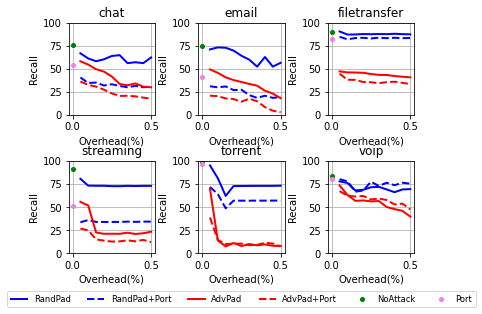

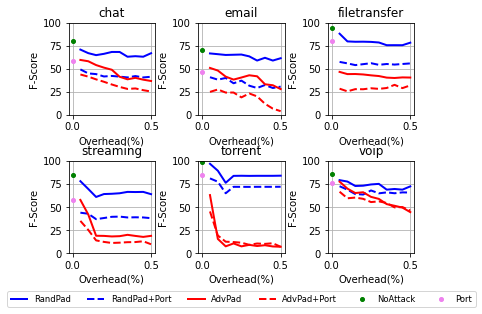

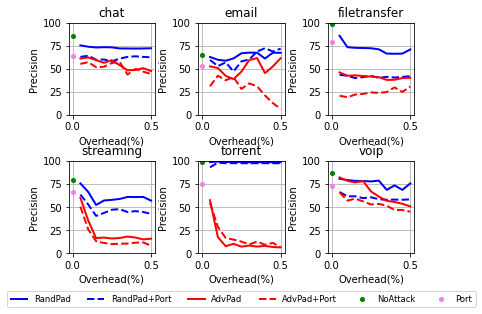

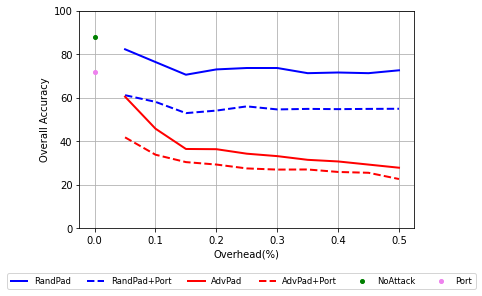

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

result_stat = np.array(results_statistics_array)
np.save('AttacksResult.npy',result_stat)
result_index = 0
result_index = 0
f_score_name = "F-Score"
precision_name = "Precision"
recal_name = "Recall"
overhead_name = "Overhead"
accuracy_name = "Accuracy"

class_name = data.name[index_name]
for attack in AttackList:
    for i in range(len(class_name)):
        attack[f_score_name + class_name[i]] = result_stat[result_index, 0][ i]
        attack[precision_name + class_name[i]] = result_stat[result_index, 1][ i]
        attack[recal_name + class_name[i]] = result_stat[result_index, 2][ i]
    attack[accuracy_name] = result_stat[result_index,3]
    result_index += 1



#AttackList = np.load('AttacksResult.npy',allow_pickle=True)
#print("saved")


class_name = ['chat','email','filetransfer','streaming','torrent','voip']





flag_recall = 0
class Attack_Result:
    def __init__(self,atc_res_list,metric_name,cls_name):
        self.attack_res = {}
        natural = []
        port = []
        rand = []
        advpad = []
        rand_port = []
        advpad_port = []
        overhead = []
        for attack in atc_res_list:
            assert (attack["AdvPadAttack"] != attack["RandAttack"]), "Attack information is wrong"
            if attack["AdvPadAttack"] == 1 and attack["Steps"] == 0:
                if attack["PortAttack"] == 0:
                    natural.append(attack[metric_name+cls_name])
                else:
                    port.append(attack[metric_name+cls_name])
            if attack["AdvPadAttack"] == 1 and attack["Steps"] > 0:
                if attack["PortAttack"] == 0:
                    advpad.append(attack[metric_name+cls_name])
                    overhead.append(attack["ProportionalSize"])
                else:
                    advpad_port.append(attack[metric_name+cls_name])
            if attack["RandAttack"] == 1:
                if attack["PortAttack"] == 0:
                    rand.append(attack[metric_name+cls_name])
                else:
                    rand_port.append(attack[metric_name+cls_name])
        self.attack_res["natural"] = np.array(natural)
        self.attack_res["port"] = np.array(port)
        self.attack_res["rand"] = np.array(rand)
        self.attack_res["rand_port"] = np.array(rand_port)
        self.attack_res["advpad"] = np.array(advpad)
        self.attack_res["advpad_port"] = np.array(advpad_port)
        self.attack_res["overhead"] = np.array(overhead)


class metrics:
        def __init__(self,atc_res_list,cls_name=None):
            if cls_name:
                self.f_score = Attack_Result(atc_res_list,f_score_name,cls_name)
                self.precision = Attack_Result(atc_res_list,precision_name,cls_name)
                self.recall = Attack_Result(atc_res_list,recal_name,cls_name)
            else:
                self.accuracy = Attack_Result(atc_res_list,accuracy_name,cls_name='')

class chart_data:
    def __init__(self,Attck_result_list):
        self.classes = {}
        self.classes["chat"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[0])
        self.classes["email"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[1])
        self.classes["filetransfer"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[2])
        self.classes["streaming"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[3])
        self.classes["torrent"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[4])
        self.classes["voip"] = metrics(atc_res_list=Attck_result_list,cls_name=class_name[5])

acc_data = metrics(AttackList)

data = chart_data(Attck_result_list=AttackList)




fig, axes = plt.subplots(2,3)
#fig.tight_layout(pad=1.5)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
class_index = 0
for ax in axes.flatten():
    ax.set_title(class_name[class_index])
    data.classes[class_name[class_index]].recall.attack_res["overhead"] = np.asarray(
        [ 0.05,0.10,0.15,0.20,0.25, 0.3, 0.35, .4, .45, .5])
    if len(data.classes[class_name[class_index]].recall.attack_res["rand"])is not 0 :
        ax.plot(data.classes[class_name[class_index]].recall.attack_res["overhead"], data.classes[class_name[class_index]].recall.attack_res["rand"],
               color='blue', linewidth=2, label="RandPad")
    if len(data.classes[class_name[class_index]].recall.attack_res["rand_port"]) is not 0 :
        ax.plot(data.classes[class_name[class_index]].recall.attack_res["overhead"], data.classes[class_name[class_index]].recall.attack_res["rand_port"],
              color='blue', linewidth=2,linestyle='dashed', label="RandPad+Port")
    if len(data.classes[class_name[class_index]].recall.attack_res["advpad"]) is not 0 :
        ax.plot(data.classes[class_name[class_index]].recall.attack_res["overhead"], data.classes[class_name[class_index]].recall.attack_res["advpad"],
              color='red', linewidth=2, label="AdvPad")
    if len(data.classes[class_name[class_index]].recall.attack_res["advpad_port"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].recall.attack_res["overhead"],data.classes[class_name[class_index]].recall.attack_res["advpad_port"],
            color='red', linewidth=2, linestyle='dashed', label="AdvPad+Port")
    if data.classes[class_name[class_index]].recall.attack_res["natural"]:
        ax.plot([0], data.classes[class_name[class_index]].recall.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
             color='green', linewidth=0, label="NoAttack")
    if data.classes[class_name[class_index]].recall.attack_res["port"]:
        ax.plot([0], data.classes[class_name[class_index]].recall.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
             color='violet', linewidth=0, label="Port")
    ax.set( ylim=(0, 100))
    ax.grid()
    if class_index == 4:
        handles, labels = ax.get_legend_handles_labels()

    class_index += 1



for ax in axes.flat:
    ax.set(xlabel='Overhead(%)', ylabel='Recall')
fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
fig.show()



fig, axes = plt.subplots(2, 3)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

class_index = 0
for ax in axes.flatten():
    ax.set_title(class_name[class_index])
    data.classes[class_name[class_index]].f_score.attack_res["overhead"] = np.asarray(
        [ 0.05, 0.10,0.15,0.20,0.25, 0.3, 0.35, .4, .45, .5])
    if len(data.classes[class_name[class_index]].f_score.attack_res["rand"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].f_score.attack_res["overhead"], data.classes[class_name[class_index]].f_score.attack_res["rand"],
               color='blue', linewidth=2, label="RandPad")
    if len(data.classes[class_name[class_index]].f_score.attack_res["rand_port"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].f_score.attack_res["overhead"], data.classes[class_name[class_index]].f_score.attack_res["rand_port"],
              color='blue', linewidth=2,linestyle='dashed', label="RandPad+Port")
    if len(data.classes[class_name[class_index]].f_score.attack_res["advpad"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].f_score.attack_res["overhead"], data.classes[class_name[class_index]].f_score.attack_res["advpad"],
              color='red', linewidth=2, label="AdvPad")
    if len(data.classes[class_name[class_index]].f_score.attack_res["advpad_port"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].f_score.attack_res["overhead"],data.classes[class_name[class_index]].f_score.attack_res["advpad_port"],
            color='red', linewidth=2, linestyle='dashed', label="AdvPad+Port")
    if data.classes[class_name[class_index]].f_score.attack_res["natural"]:
        ax.plot([0], data.classes[class_name[class_index]].f_score.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
             color='green', linewidth=0, label="NoAttack")
    if data.classes[class_name[class_index]].f_score.attack_res["port"]:
        ax.plot([0], data.classes[class_name[class_index]].f_score.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
             color='violet', linewidth=0, label="Port")
    ax.set( ylim=(0, 100))
    ax.grid()
    if class_index == 4:
        handles, labels = ax.get_legend_handles_labels()

    class_index += 1

for ax in axes.flat:
    ax.set(xlabel='Overhead(%)', ylabel='F-Score')
fig.legend( handles, labels ,loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
fig.show()


fig, axes = plt.subplots(2,3)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

class_index = 0
for ax in axes.flatten():
    ax.set_title(class_name[class_index])
    data.classes[class_name[class_index]].precision.attack_res["overhead"] = np.asarray(
        [0.05,0.10,0.15,0.20,0.25, 0.3, 0.35, .4, .45, .5])
    if len(data.classes[class_name[class_index]].precision.attack_res["rand"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].precision.attack_res["overhead"], data.classes[class_name[class_index]].precision.attack_res["rand"],
               color='blue', linewidth=2, label="RandPad")
    if len(data.classes[class_name[class_index]].precision.attack_res["rand_port"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].precision.attack_res["overhead"], data.classes[class_name[class_index]].precision.attack_res["rand_port"],
              color='blue', linewidth=2,linestyle='dashed', label="RandPad+Port")
    if len(data.classes[class_name[class_index]].precision.attack_res["advpad"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].precision.attack_res["overhead"], data.classes[class_name[class_index]].precision.attack_res["advpad"],
              color='red', linewidth=2, label="AdvPad")
    if len(data.classes[class_name[class_index]].precision.attack_res["advpad_port"]) is not 0:
        ax.plot(data.classes[class_name[class_index]].precision.attack_res["overhead"],data.classes[class_name[class_index]].precision.attack_res["advpad_port"],
            color='red', linewidth=2, linestyle='dashed', label="AdvPad+Port")
    if data.classes[class_name[class_index]].precision.attack_res["natural"]:
        ax.plot([0], data.classes[class_name[class_index]].precision.attack_res["natural"], marker='o', markerfacecolor='green', markersize=4,
             color='green', linewidth=0, label="NoAttack")
    if data.classes[class_name[class_index]].precision.attack_res["port"]:
        ax.plot([0], data.classes[class_name[class_index]].precision.attack_res["port"], marker='o', markerfacecolor='violet', markersize=4,
             color='violet', linewidth=0, label="Port")
    ax.set( ylim=(0, 100))
    ax.grid()
    if class_index == 4:
        handles, labels = ax.get_legend_handles_labels()

    class_index += 1
for ax in axes.flat:
    ax.set(xlabel='Overhead(%)', ylabel='Precision')
fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
fig.show()

fig = plt.figure()
ax = fig.add_subplot(111)
if True:
    if len(acc_data.accuracy.attack_res['rand']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['overhead'],acc_data.accuracy.attack_res['rand'],color='blue', linewidth=2, label="RandPad")
    if len(acc_data.accuracy.attack_res['rand_port']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['overhead'],acc_data.accuracy.attack_res['rand_port'],color='blue', linewidth=2,linestyle='dashed', label="RandPad+Port")
    if len(acc_data.accuracy.attack_res['advpad']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['overhead'],acc_data.accuracy.attack_res['advpad'],color='red', linewidth=2, label="AdvPad")
    if len(acc_data.accuracy.attack_res['advpad_port']) is not 0:
        ax.plot(acc_data.accuracy.attack_res['overhead'],acc_data.accuracy.attack_res['advpad_port'],color='red', linewidth=2, linestyle='dashed', label="AdvPad+Port")
    if len(acc_data.accuracy.attack_res['natural']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['natural'], marker='o', markerfacecolor='green', markersize=4,
                 color='green', linewidth=0, label="NoAttack")
    if len(acc_data.accuracy.attack_res['port']) is not 0:
        ax.plot([0.0],acc_data.accuracy.attack_res['port'],marker='o', markerfacecolor='violet', markersize=4,
                 color='violet', linewidth=0, label="Port")
    ax.set(xlabel='Overhead(%)', ylabel='Overall Accuracy')
    ax.set( ylim=(0, 100))
    ax.grid()

fig.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure, ncol=6,fontsize='small' )
fig.show()





